# Gibbs Sampling
We use Gibbs sampling to estimate expectations that would otherwise required summations over exponentially many states. To test our Gibbs sampling algorithm, we instantiate an exponential model of the form:
$$
P^{(3)}(\{\sigma_i\}) = \frac{1}{Z} \exp \left[ \sum_i h_i \sigma_i + \sum_{i< j} J_{ij}\sigma_i\sigma_j + \sum_{i<j<k} K_{ijk}\sigma_i\sigma_j\sigma_k  \right]
$$
by randomly sampling the interaction parameters $h,J,K$. We then compare expectations estimated from Gibbs sampling to the actual expectations of the distribution $p^{(3)}$. 

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
from MaxEnt import ThreeWise, gibbs_sampling
import time
from numba import njit, prange

In [2]:
def sim_p_true(N, h_m=0.02, J_m=0.05, K_m=0.02, h=None, J=None, K=None):
    """
    Function that creates a distribution that includes up to 3-wise interactions, by randomly sampling the interaction weights if h,J,K set to None
    Otherwise, uses the provided interactions parameters.
    """
    if not isinstance(h,np.ndarray):
        h = np.zeros(N)
        for i in range(N):
            h[i] = np.log(np.abs(1/np.random.exponential(h_m) - 1))
    
    if not isinstance(J,np.ndarray):  
        J = np.zeros((N,N))
        for i in range(N-1):
            for j in range(i+1,N):
                J[i,j] = np.random.normal(J_m, 0.8)
    
    if not isinstance(K,np.ndarray):
        K = np.zeros((N,N,N))
        for i in range(N-2):
            for j in range(i+1,N-1):
                for k in range(j+1,N):
                    K[i,j,k] = np.random.normal(K_m, 0.5)
    
    p_true = ThreeWise(N, h, J, K)
    return p_true

## Perform sampling and compare sample expectations to true expectations

In [3]:
N = 5
p_true = sim_p_true(N,0.2,0.1,0.1)

In [5]:
h,J,K = p_true.h, p_true.J, p_true.K
@njit
def p(s):
    return np.exp(-(h.dot(s) + J.dot(s).dot(s) + np.sum(K*s,axis=2).dot(s).dot(s)))
init_state = np.random.binomial(1,p_true.averages()) #prob of neurons firing
M = 1000000
chains = 1 # need chains = 1 at this stage

start = time.time()
samples = gibbs_sampling(p,init_state,M,avg_every=1,burn_in=0)
stop = time.time()
print(f"Time to generate {M} samples",stop-start)
print(samples.shape)

Time to generate 1000000 samples 12.418111085891724
(1000000, 5)


In [6]:
means_true = p_true.averages()
dp = 5 #decimal places
print("True means", np.round(means_true,dp), "Sample means", np.round(np.mean(samples, axis=0),dp), sep="\n")
print("Difference in means", means_true - np.mean(samples,axis=0), sep="\n")

corrs_true = p_true.correlations()
corrs_sample = np.triu((samples.T@samples) / M,k=1)
print("True correlations", np.round(corrs_true,dp), "Sample correlations", np.round(corrs_sample,dp), sep="\n")
print("Difference in correlations", corrs_true - corrs_sample, sep="\n")

True means
[0.46792 0.1121  0.17374 0.61007 0.32547]
Sample means
[0.4683  0.11194 0.17432 0.60995 0.32614]
Difference in means
[-0.00037842  0.00016665 -0.00057119  0.00012005 -0.00066006]
True correlations
[[0.      0.06244 0.05195 0.31839 0.13618]
 [0.      0.      0.01837 0.07846 0.06353]
 [0.      0.      0.      0.09844 0.06112]
 [0.      0.      0.      0.      0.21985]
 [0.      0.      0.      0.      0.     ]]
Sample correlations
[[0.      0.06227 0.05228 0.3177  0.13588]
 [0.      0.      0.0186  0.07819 0.06309]
 [0.      0.      0.      0.09867 0.06137]
 [0.      0.      0.      0.      0.21958]
 [0.      0.      0.      0.      0.     ]]
Difference in correlations
[[ 0.          0.0001713  -0.00032898  0.00069018  0.00029807]
 [ 0.          0.         -0.0002287   0.00027204  0.00044414]
 [ 0.          0.          0.         -0.00023326 -0.00025672]
 [ 0.          0.          0.          0.          0.00027383]
 [ 0.          0.          0.          0.          0.        

## Determining burn-in and average over
We want to see what sort of burn-in we should include (how many of the initial states to discard from the average), as well as whether we might want average over every ith state. 

### Burn-in

In [7]:
start = 0 
stop = 500000 
incr = 1000 
burn_ins = np.arange(start,stop,incr)
sample_len = M - burn_ins[-1] # how many samples we select after discarding the burn in
error = np.zeros(len(burn_ins)) 

for bi in range(len(burn_ins)):
    burn_in = burn_ins[bi]
    subset = samples[burn_in:sample_len+burn_in]
    error[bi] = np.sum( np.abs( np.mean(subset,axis=0) - means_true))

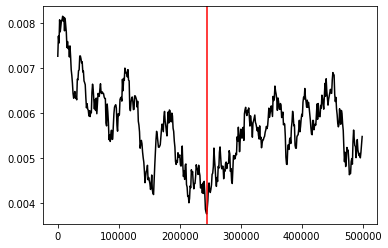

Min error at
244000
Means computed using burn-in
[0.46748503 0.11194411 0.17620758 0.61022954 0.32601996]
True means
[0.46792158 0.11210165 0.17374381 0.61007205 0.32547494]


In [8]:
plt.plot(burn_ins, error,"k")
min_error = np.argmin(error)
plt.axvline(burn_ins[min_error],color="r")
plt.show()
print("Min error at", burn_ins[min_error], "Means computed using burn-in", np.mean(samples[burn_ins[min_error]:sample_len+burn_ins[min_error]],axis=0), "True means",means_true, sep="\n")

### Average over

We start by looking at how correlated subsequent states in our Markov chain are

In [9]:
offsets = np.arange(1,20)
error = np.zeros(len(offsets))
tail = M-offsets[-1]

for o in range(len(offsets)):
    offset = offsets[o]
    error[o] = np.mean(samples[:tail]*samples[offset:tail+offset]) #correlation between states

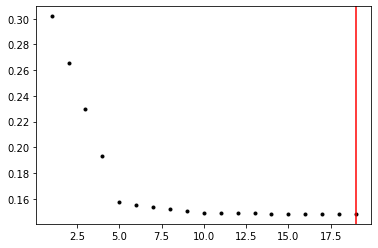

In [10]:
plt.plot(offsets, error,"k.")
min_error = np.argmin(error)
plt.axvline(offsets[min_error],color="r")
plt.show()

In [11]:
av_over = [1,2,5,10,20]
error = np.zeros(len(av_over))
size = int(M/av_over[-1])

for ai in range(len(av_over)):
    subset = samples.reshape(av_over[ai],-1,N)[0]
    subset = subset[:size] #ensure all subset have the same size
    error[ai] = np.mean( np.abs(np.mean(subset,axis=0)-means_true) )

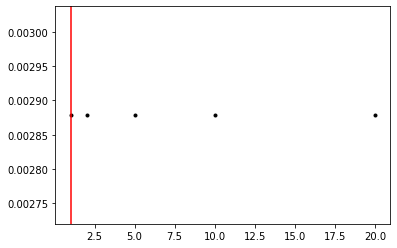

Means produced by averaging over every 1 sample
[0.4712  0.113   0.171   0.6134  0.32962]
True means
[0.46792158 0.11210165 0.17374381 0.61007205 0.32547494]


In [12]:
plt.plot(av_over, error,"k.")
min_error = np.argmin(error)
plt.axvline(av_over[min_error],color="r")
plt.show()
print(f"Means produced by averaging over every {av_over[min_error]} sample", np.mean(samples.reshape(av_over[min_error],-1,N)[0][:size],axis=0), "True means",means_true, sep="\n")